# Setting

In [1]:
import pandas as pd
import torch
import random
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import numpy as np

from models.shared_perceiver import CustomDataset, Perceiver, CombinedModel

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

file_path = '/home/youlee/n24news/n24news/captions_and_labels.csv'
data = pd.read_csv(file_path)

groups = [
    ["Opinion", "Art & Design", "Television"],
    ["Music", "Travel", "Real Estate"],
    ["Books", "Theater", "Health"],
    ["Sports", "Science", "Food"],
    ["Fashion & Style", "Movies", "Technology"],
    ["Dance", "Media", "Style"]
]

output_paths = []
for i, group_labels in enumerate(groups, 1):
    group_data = data[data['Label'].isin(group_labels)]
    output_path = f'/home/youlee/n24news/n24news/regroup_{i}.csv'
    group_data.to_csv(output_path, index=False)
    output_paths.append(output_path)

print("생성된 그룹별 CSV 파일 경로:")
for path in output_paths:
    print(path)

생성된 그룹별 CSV 파일 경로:
/home/youlee/n24news/n24news/regroup_1.csv
/home/youlee/n24news/n24news/regroup_2.csv
/home/youlee/n24news/n24news/regroup_3.csv
/home/youlee/n24news/n24news/regroup_4.csv
/home/youlee/n24news/n24news/regroup_5.csv
/home/youlee/n24news/n24news/regroup_6.csv


In [2]:
def seed_everything(seed):
    torch.manual_seed(seed) #torch를 거치는 모든 난수들의 생성순서를 고정한다
    torch.cuda.manual_seed(seed) #cuda를 사용하는 메소드들의 난수시드는 따로 고정해줘야한다 
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True #딥러닝에 특화된 CuDNN의 난수시드도 고정 
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed) #numpy를 사용할 경우 고정
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정
seed_everything(42)

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 128

In [4]:
def tokenize_data(df, tokenizer=BertTokenizer.from_pretrained('bert-base-uncased'), MAX_LENGTH=128):
    input_ids, attention_masks = [], []
    df['Caption'] = df['Caption'].astype(str).fillna("")

    for text in df['Caption']:
        encoded = tokenizer(
            text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'].squeeze(0))
        attention_masks.append(encoded['attention_mask'].squeeze(0))
    return torch.stack(input_ids), torch.stack(attention_masks)


# Functions

In [9]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)  
        labels = batch['labels'].to(device)
        #print(f"🚀 input_ids.shape: {input_ids.shape}") 
        optimizer.zero_grad()
        outputs = model(input_ids)  # CombinedModel의 forward 호출
        loss = criterion(outputs, labels)
        #print(f"🚀 outputs.shape: {outputs.shape}")
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)  
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [10]:
model_path = '/home/Minju/Perceiver/shared_layer_model'
loader_path = '/home/Minju/Perceiver/loader'

In [11]:
for idx, group_file in enumerate(output_paths, start=1):
    print(f"\ngroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df, tokenizer=tokenizer, MAX_LENGTH=MAX_LENGTH)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)
    sample = dataset [0]
    print(sample)
    print(len(dataset)) 

    dataloader = DataLoader(dataset, batch_size=2, shuffle=False)
    first_batch = next(iter(dataloader))
    print(first_batch)
 


group 1 처리 중...
{'input_ids': tensor([ 101, 1996, 2317, 2160, 2003, 1037, 4556, 2806, 3538, 1997, 4294, 1010,
        4427, 2011, 3306, 1998, 3142, 3121, 1012,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0,

# Train 시작


group 1 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1046, train acc: 0.3308
                               test loss: 1.0985, test acc: 0.3425
    epoch 5/40: train loss: 1.1003, train acc: 0.3393
                               test loss: 1.0995, test acc: 0.3279
    epoch 10/40: train loss: 1.0990, train acc: 0.3335
                               test loss: 1.1008, test acc: 0.3279
    epoch 15/40: train loss: 1.0991, train acc: 0.3308
                               test loss: 1.0999, test acc: 0.3296
    epoch 20/40: train loss: 1.0990, train acc: 0.3354
                               test loss: 1.0994, test acc: 0.3296
    epoch 25/40: train loss: 1.0989, train acc: 0.3302
                               test loss: 1.0988, test acc: 0.3296
    epoch 30/40: train loss: 1.0987, train acc: 0.3385
                               test loss: 1.0992, test acc: 0.3296
    epoch 35/40: train loss: 1.0987, train acc: 0.3376
                               test loss: 1.0989, test a

/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



  fold 2/2 처리 중...
    epoch 1/40: train loss: 1.1043, train acc: 0.3307
                               test loss: 1.1000, test acc: 0.3264
    epoch 5/40: train loss: 1.0994, train acc: 0.3312
                               test loss: 1.0991, test acc: 0.3376
    epoch 10/40: train loss: 1.0991, train acc: 0.3400
                               test loss: 1.0991, test acc: 0.3264
    epoch 15/40: train loss: 1.0991, train acc: 0.3362
                               test loss: 1.0988, test acc: 0.3376
    epoch 20/40: train loss: 1.0992, train acc: 0.3342
                               test loss: 1.1010, test acc: 0.3264
    epoch 25/40: train loss: 1.0988, train acc: 0.3425
                               test loss: 1.0988, test acc: 0.3264
    epoch 30/40: train loss: 1.0987, train acc: 0.3249
                               test loss: 1.0991, test acc: 0.3264
    epoch 35/40: train loss: 1.0986, train acc: 0.3425
                               test loss: 1.0991, test acc: 0.3264
    ep

/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


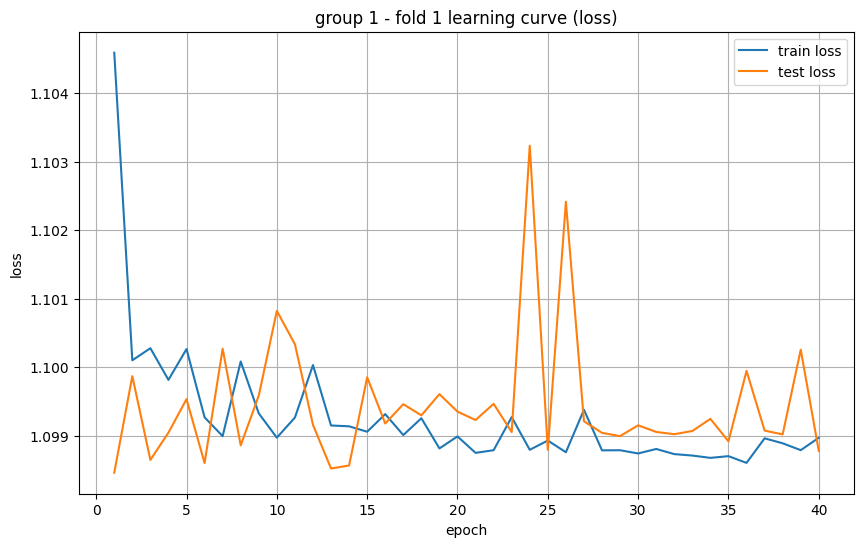

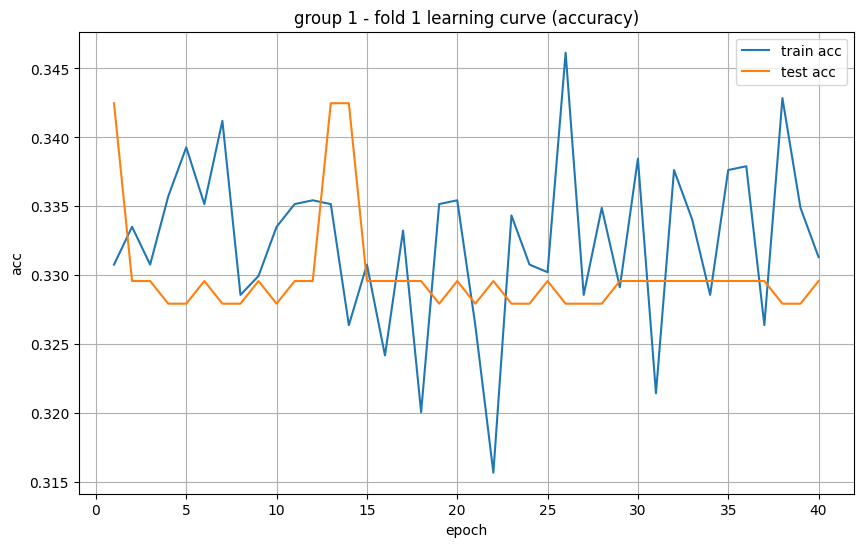

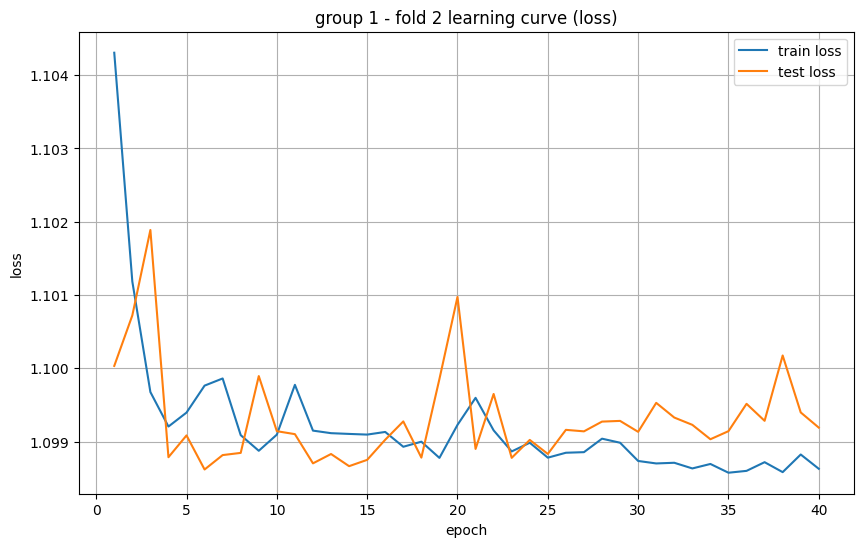

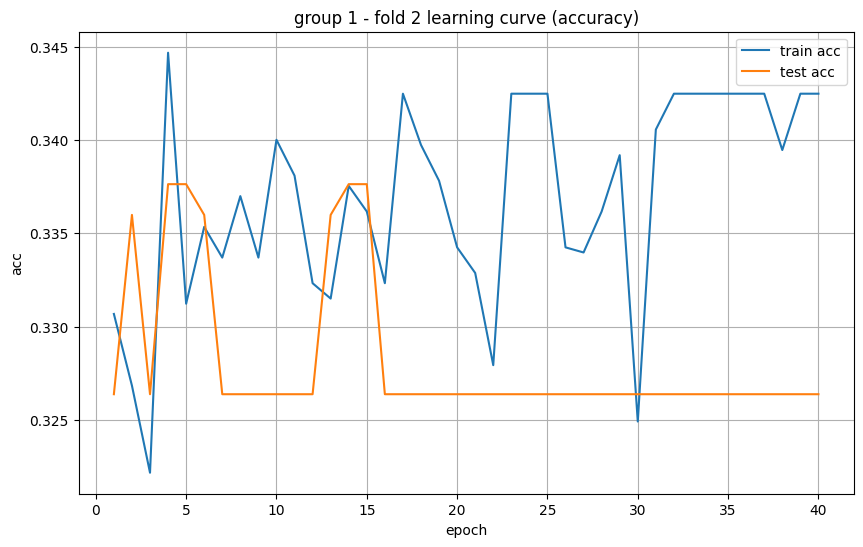

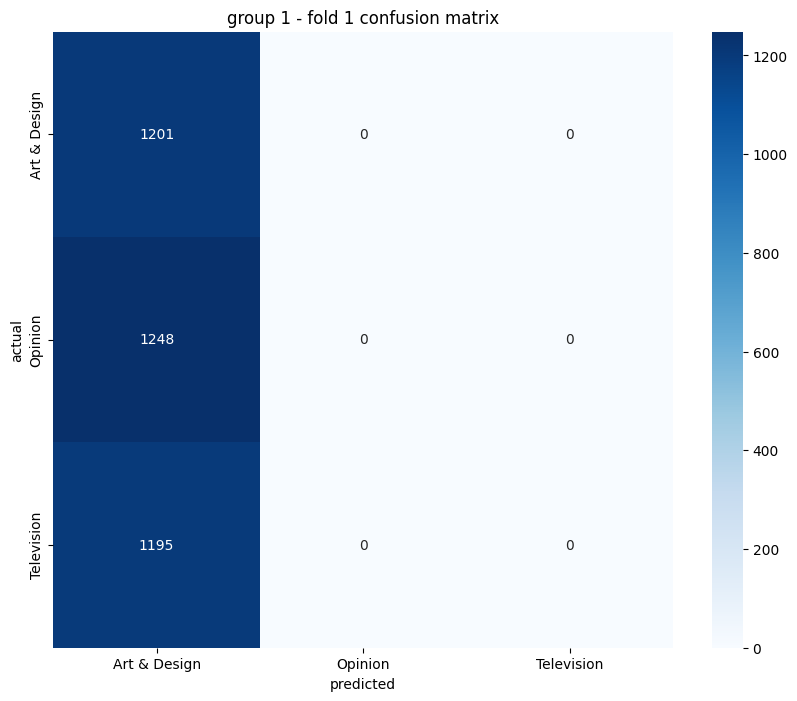

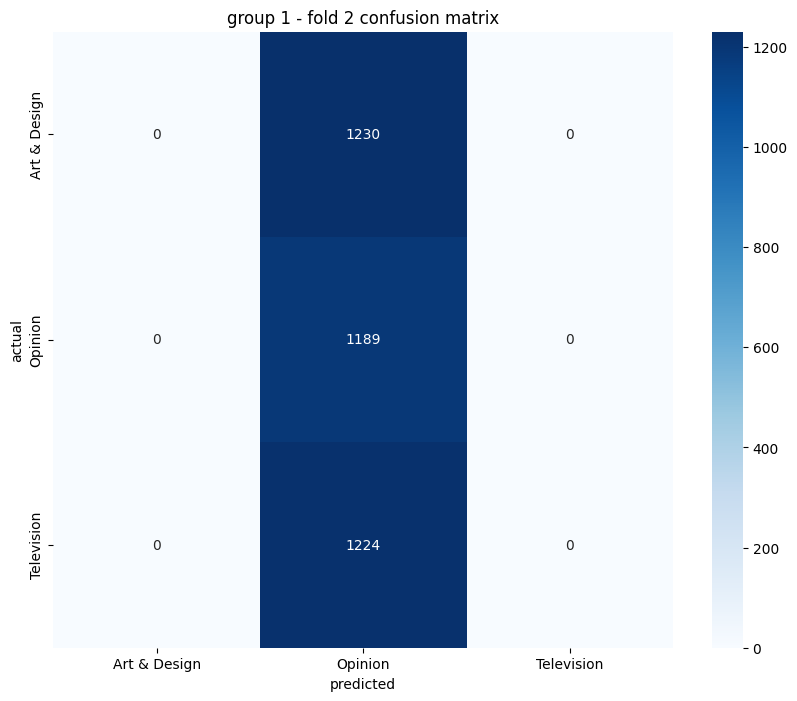


group 2 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1038, train acc: 0.3065
                               test loss: 1.1001, test acc: 0.3300
    epoch 5/40: train loss: 1.1005, train acc: 0.3245
                               test loss: 1.0986, test acc: 0.3350
    epoch 10/40: train loss: 1.0997, train acc: 0.3195
                               test loss: 1.0986, test acc: 0.3350
    epoch 15/40: train loss: 1.0993, train acc: 0.3306
                               test loss: 1.0986, test acc: 0.3350
    epoch 20/40: train loss: 1.0989, train acc: 0.3259
                               test loss: 1.0987, test acc: 0.3350
    epoch 25/40: train loss: 1.0989, train acc: 0.3286
                               test loss: 1.0988, test acc: 0.3300
    epoch 30/40: train loss: 1.0990, train acc: 0.3289
                               test loss: 1.0987, test acc: 0.3350
    epoch 35/40: train loss: 1.0993, train acc: 0.3427
                               test loss: 1.1002, test a

/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



  fold 2/2 처리 중...
    epoch 1/40: train loss: 1.1053, train acc: 0.3336
                               test loss: 1.1019, test acc: 0.3314
    epoch 5/40: train loss: 1.0995, train acc: 0.3317
                               test loss: 1.0987, test acc: 0.3314
    epoch 10/40: train loss: 1.0989, train acc: 0.3358
                               test loss: 1.0990, test acc: 0.3322
    epoch 15/40: train loss: 1.0992, train acc: 0.3181
                               test loss: 1.0986, test acc: 0.3364
    epoch 20/40: train loss: 1.0991, train acc: 0.3286
                               test loss: 1.0987, test acc: 0.3364
    epoch 25/40: train loss: 1.0989, train acc: 0.3289
                               test loss: 1.0987, test acc: 0.3314
    epoch 30/40: train loss: 1.0987, train acc: 0.3333
                               test loss: 1.0987, test acc: 0.3314
    epoch 35/40: train loss: 1.0990, train acc: 0.3275
                               test loss: 1.0986, test acc: 0.3322
    ep

/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


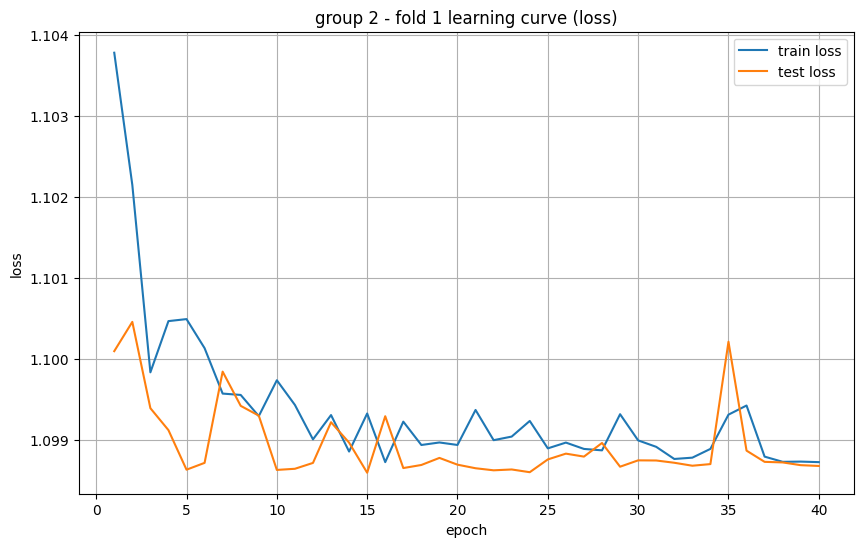

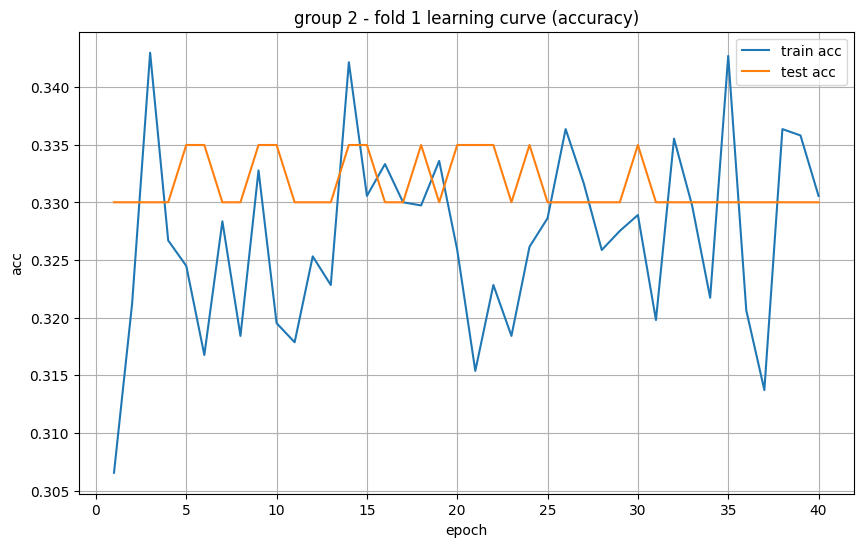

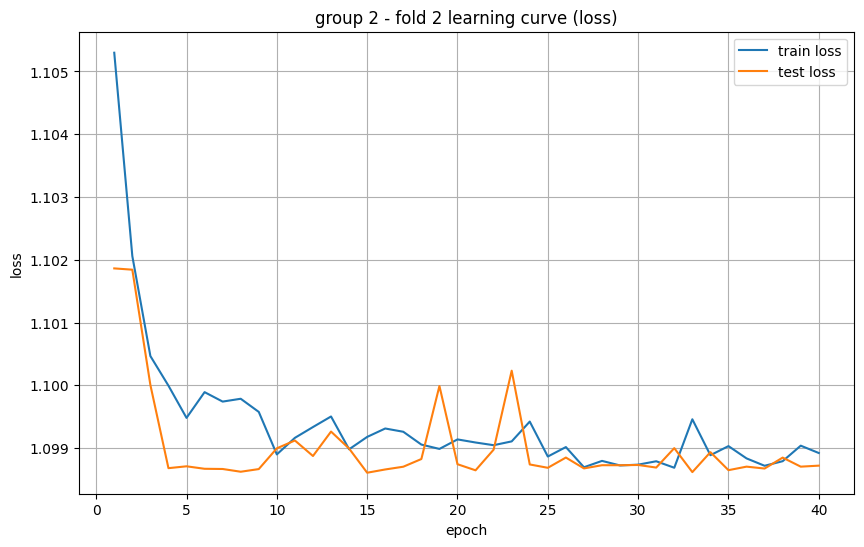

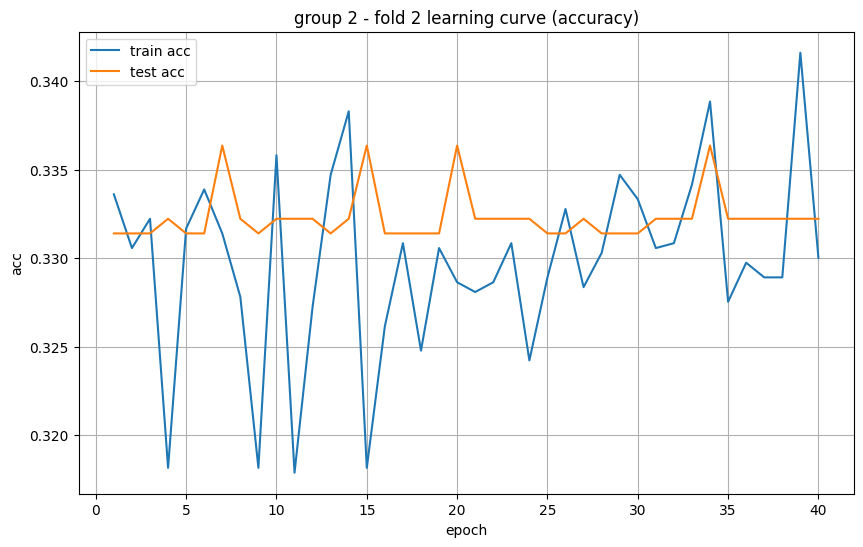

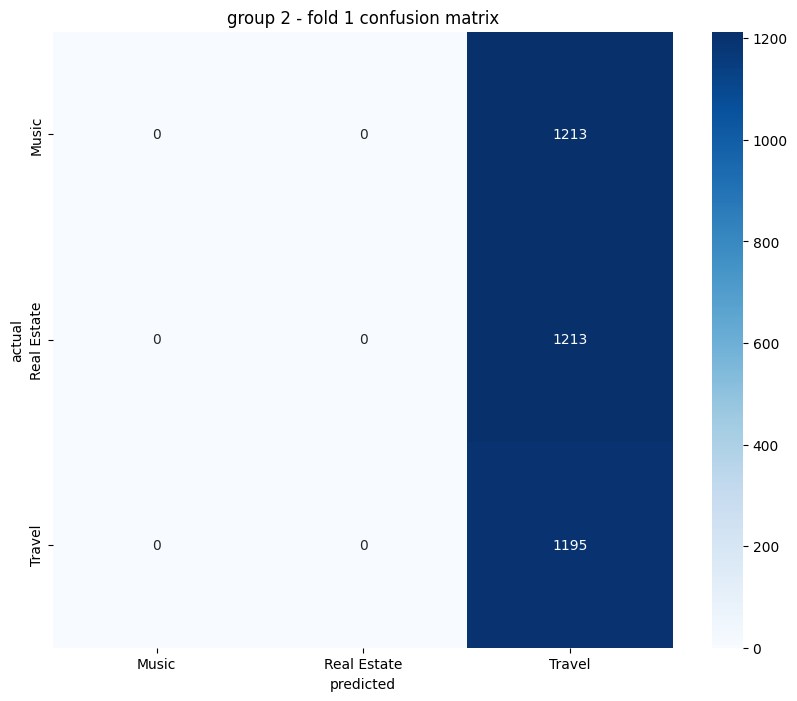

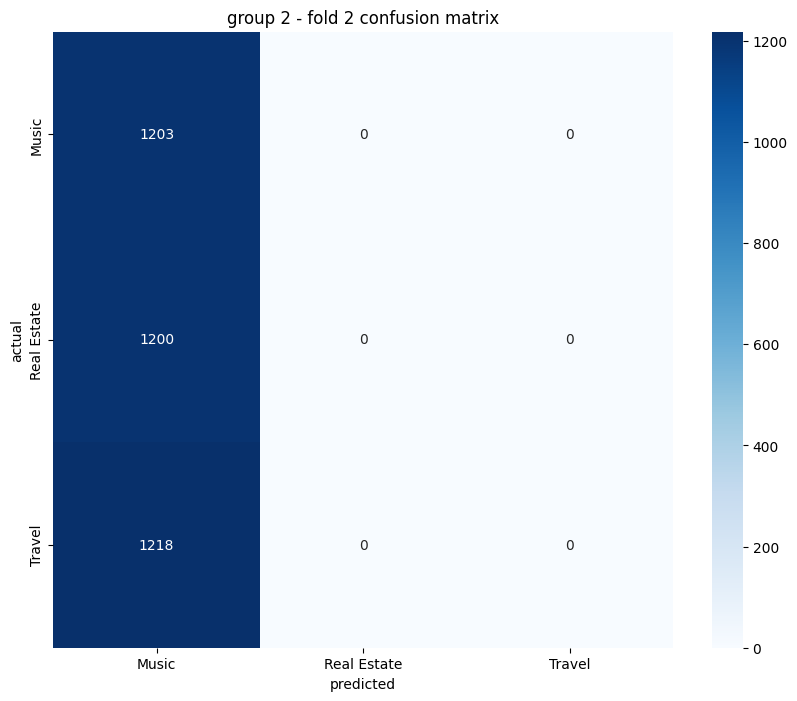


group 3 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1028, train acc: 0.3289
                               test loss: 1.1025, test acc: 0.3206
    epoch 5/40: train loss: 1.0994, train acc: 0.3364
                               test loss: 1.1013, test acc: 0.3206
    epoch 10/40: train loss: 1.0989, train acc: 0.3466
                               test loss: 1.0996, test acc: 0.3206
    epoch 15/40: train loss: 1.0995, train acc: 0.3358
                               test loss: 1.0996, test acc: 0.3206
    epoch 20/40: train loss: 1.0992, train acc: 0.3466
                               test loss: 1.1012, test acc: 0.3206
    epoch 25/40: train loss: 1.0994, train acc: 0.3466
                               test loss: 1.1017, test acc: 0.3206
    epoch 30/40: train loss: 1.0985, train acc: 0.3466
                               test loss: 1.0999, test acc: 0.3206
    epoch 35/40: train loss: 1.0987, train acc: 0.3466
                               test loss: 1.0998, test a

/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



  fold 2/2 처리 중...
    epoch 1/40: train loss: 1.1021, train acc: 0.3361
                               test loss: 1.1029, test acc: 0.3237
    epoch 5/40: train loss: 1.0997, train acc: 0.3286
                               test loss: 1.0990, test acc: 0.3237
    epoch 10/40: train loss: 1.0990, train acc: 0.3364
                               test loss: 1.1007, test acc: 0.3297
    epoch 15/40: train loss: 1.0988, train acc: 0.3361
                               test loss: 1.1001, test acc: 0.3237
    epoch 20/40: train loss: 1.0987, train acc: 0.3436
                               test loss: 1.1014, test acc: 0.3297
    epoch 25/40: train loss: 1.0991, train acc: 0.3242
                               test loss: 1.1005, test acc: 0.3297
    epoch 30/40: train loss: 1.0987, train acc: 0.3339
                               test loss: 1.1003, test acc: 0.3297
    epoch 35/40: train loss: 1.0985, train acc: 0.3427
                               test loss: 1.1001, test acc: 0.3237
    ep

/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


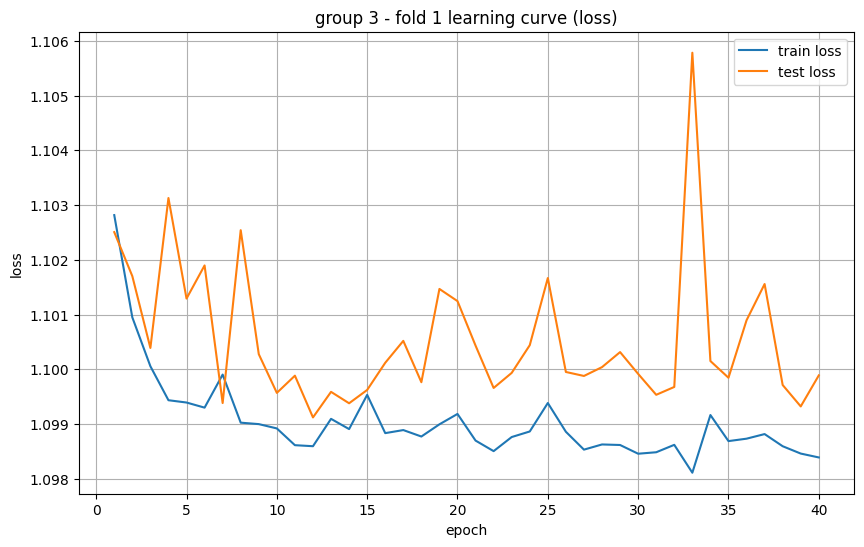

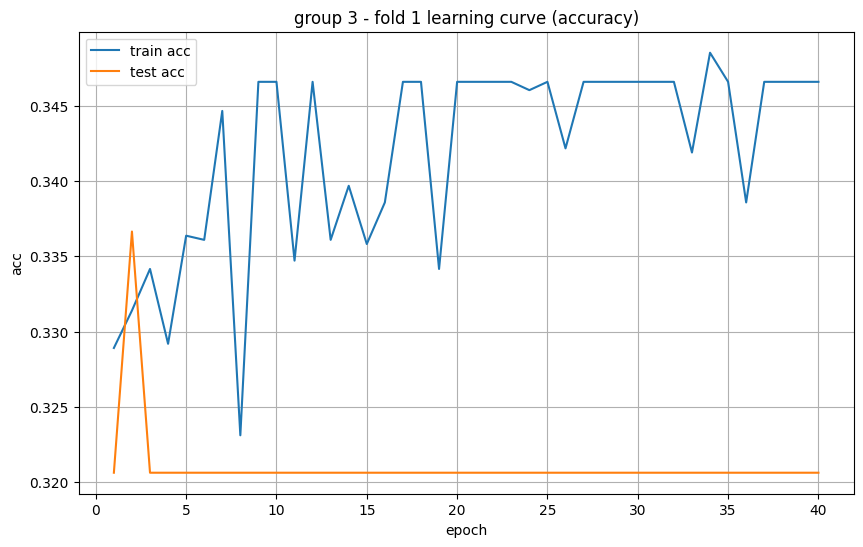

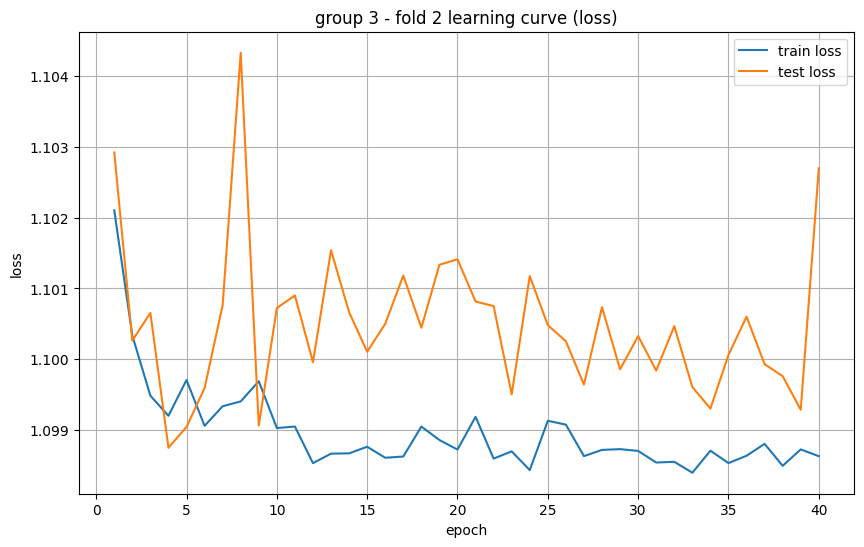

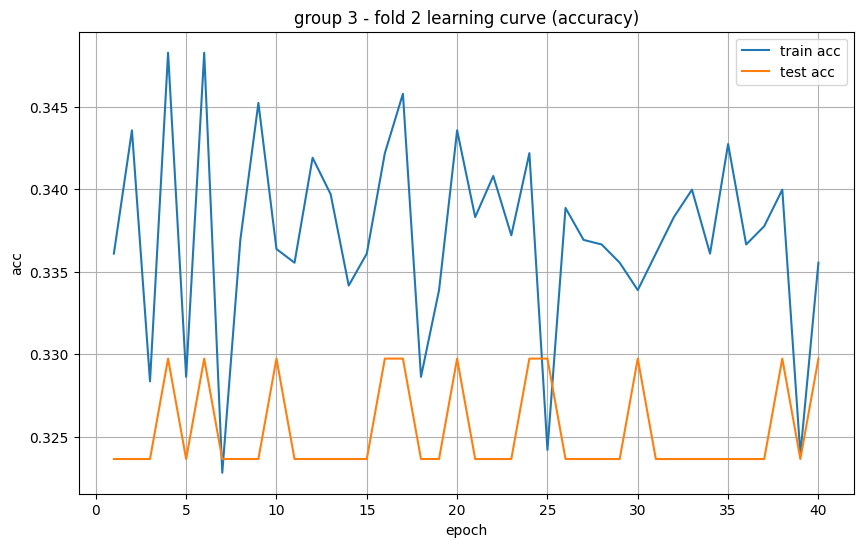

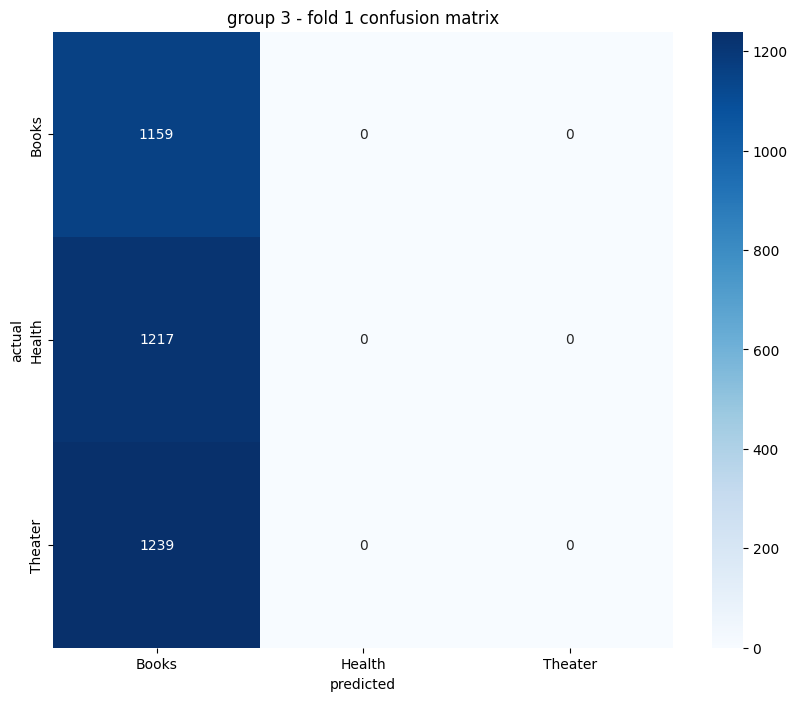

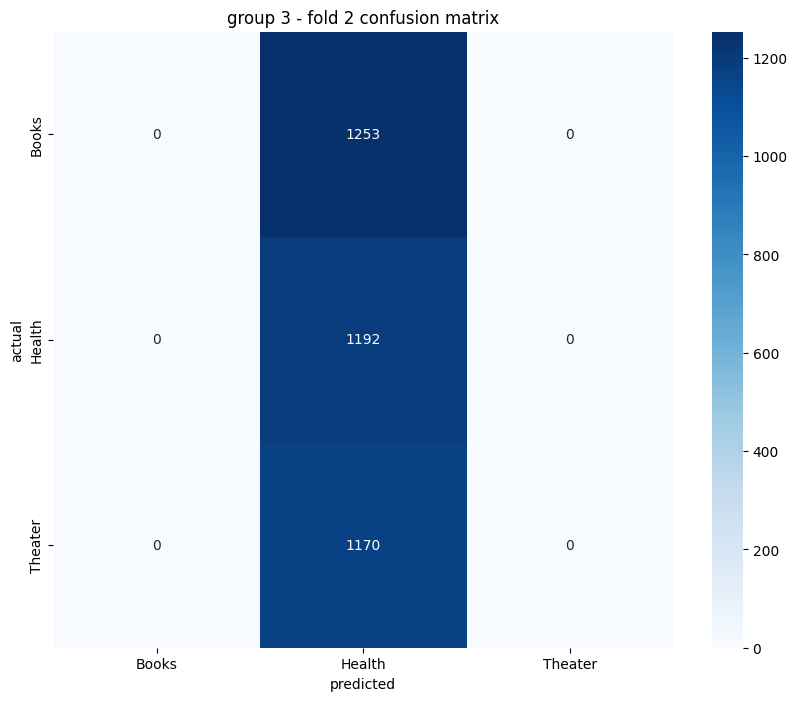


group 4 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1032, train acc: 0.3413
                               test loss: 1.1003, test acc: 0.3312
    epoch 5/40: train loss: 1.0993, train acc: 0.3330
                               test loss: 1.1049, test acc: 0.3223
    epoch 10/40: train loss: 1.0982, train acc: 0.3472
                               test loss: 1.1026, test acc: 0.3312
    epoch 15/40: train loss: 1.0987, train acc: 0.3483
                               test loss: 1.1020, test acc: 0.3223
    epoch 20/40: train loss: 1.0986, train acc: 0.3416
                               test loss: 1.1010, test acc: 0.3223
    epoch 25/40: train loss: 1.0986, train acc: 0.3410
                               test loss: 1.1018, test acc: 0.3223
    epoch 30/40: train loss: 1.0984, train acc: 0.3477
                               test loss: 1.0992, test acc: 0.3312
    epoch 35/40: train loss: 1.0981, train acc: 0.3483
                               test loss: 1.1005, test a

/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



  fold 2/2 처리 중...
    epoch 1/40: train loss: 1.1016, train acc: 0.3382
                               test loss: 1.1007, test acc: 0.3179
    epoch 5/40: train loss: 1.0993, train acc: 0.3468
                               test loss: 1.1007, test acc: 0.3179
    epoch 10/40: train loss: 1.0993, train acc: 0.3460
                               test loss: 1.1025, test acc: 0.3179
    epoch 15/40: train loss: 1.0987, train acc: 0.3465
                               test loss: 1.1008, test acc: 0.3179
    epoch 20/40: train loss: 1.0989, train acc: 0.3426
                               test loss: 1.1014, test acc: 0.3179
    epoch 25/40: train loss: 1.0990, train acc: 0.3340
                               test loss: 1.1005, test acc: 0.3179
    epoch 30/40: train loss: 1.0984, train acc: 0.3465
                               test loss: 1.0996, test acc: 0.3179
    epoch 35/40: train loss: 1.0984, train acc: 0.3465
                               test loss: 1.1006, test acc: 0.3179
    ep

/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


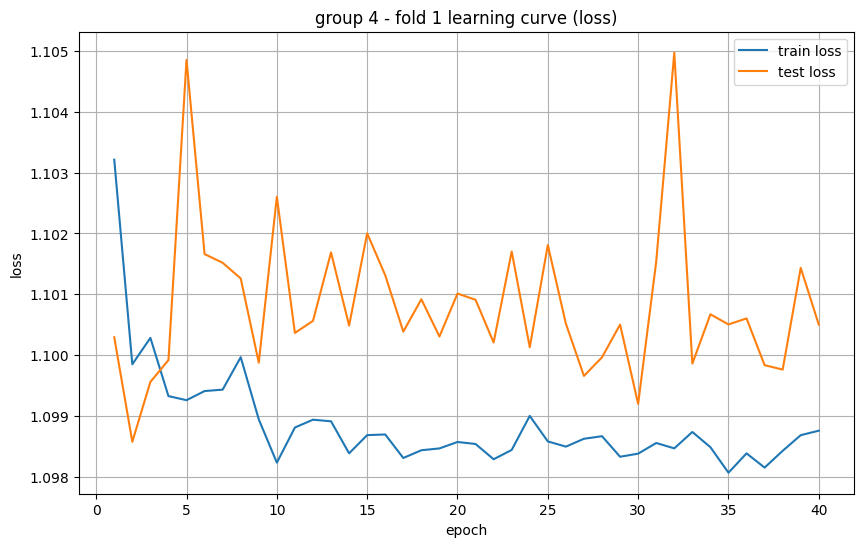

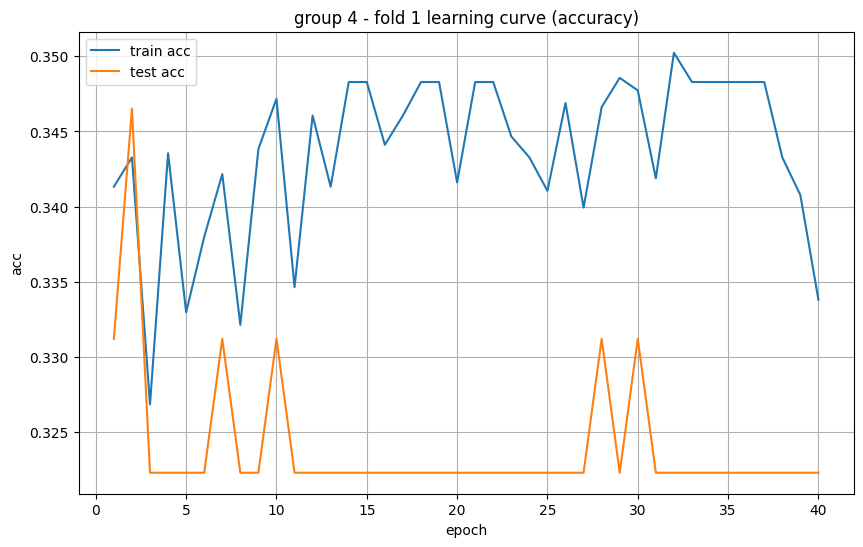

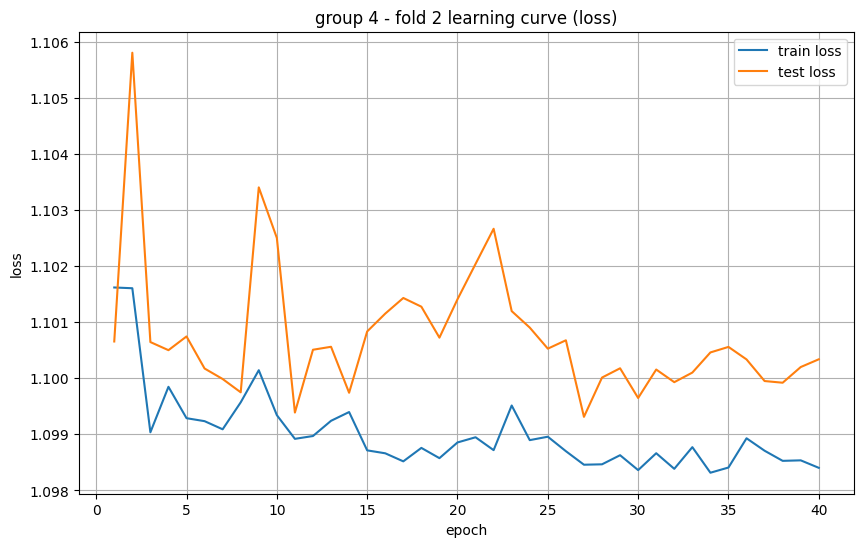

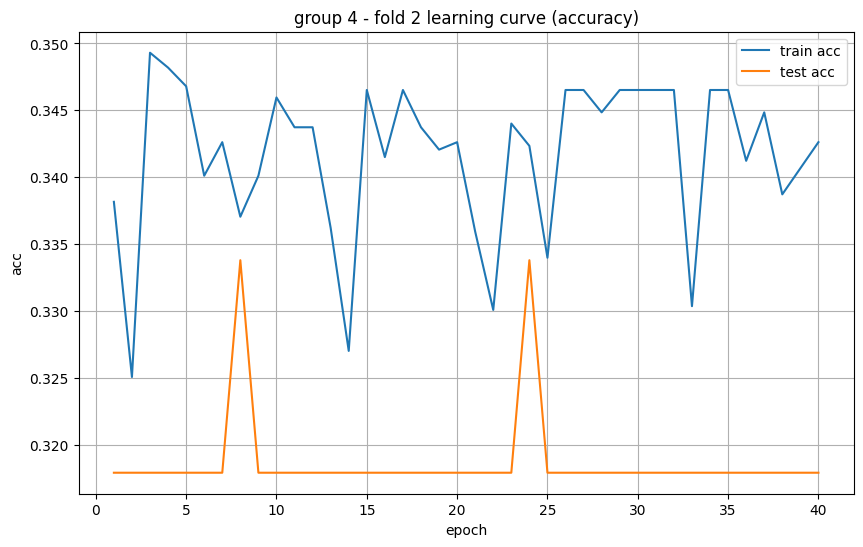

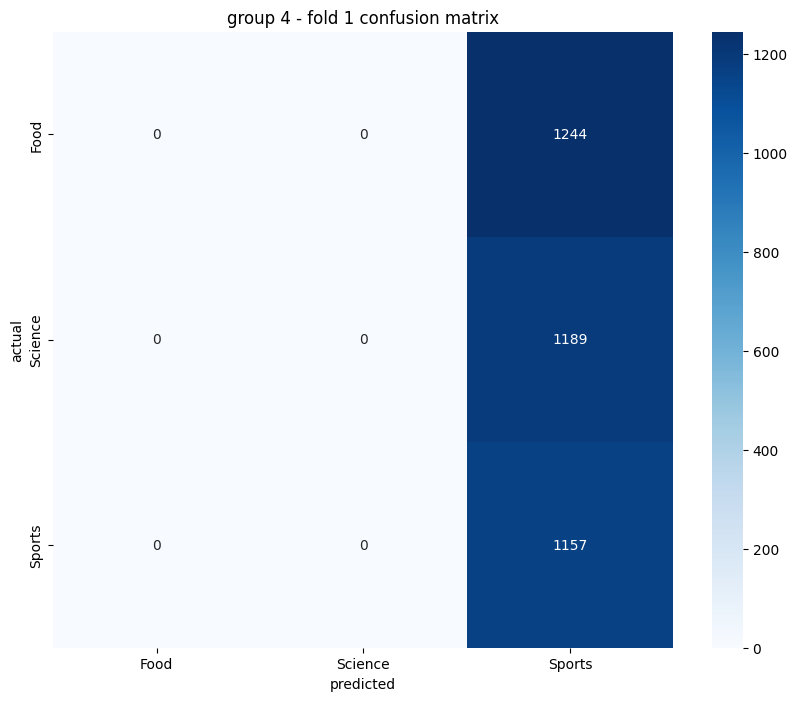

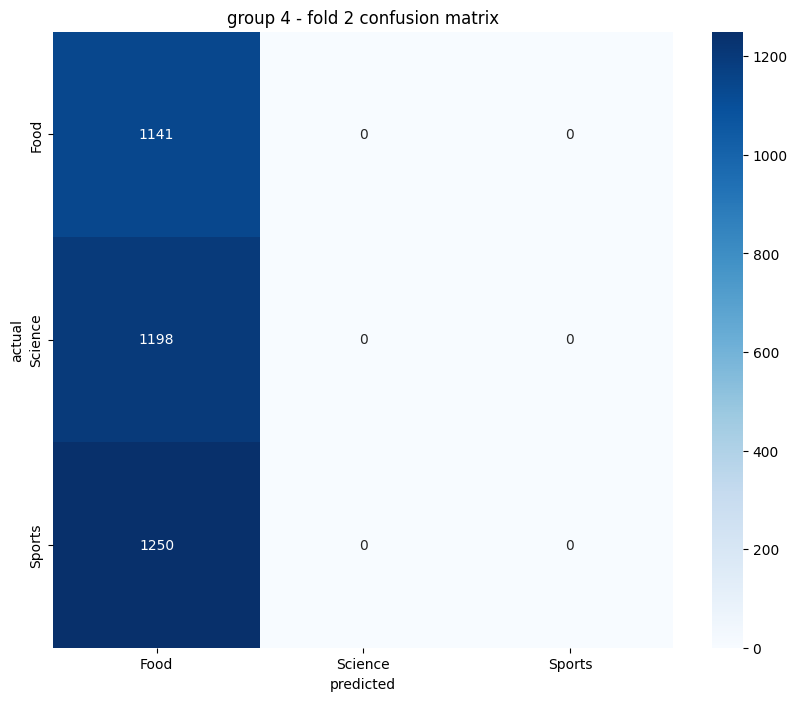


group 5 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1021, train acc: 0.3351
                               test loss: 1.0994, test acc: 0.3308
    epoch 5/40: train loss: 1.1000, train acc: 0.3368
                               test loss: 1.0988, test acc: 0.3356
    epoch 10/40: train loss: 1.0996, train acc: 0.3275
                               test loss: 1.0987, test acc: 0.3308
    epoch 15/40: train loss: 1.0992, train acc: 0.3275
                               test loss: 1.1000, test acc: 0.3308
    epoch 20/40: train loss: 1.0994, train acc: 0.3343
                               test loss: 1.0987, test acc: 0.3356
    epoch 25/40: train loss: 1.0988, train acc: 0.3309
                               test loss: 1.0989, test acc: 0.3308
    epoch 30/40: train loss: 1.0994, train acc: 0.3373
                               test loss: 1.0989, test acc: 0.3308
    epoch 35/40: train loss: 1.0991, train acc: 0.3247
                               test loss: 1.0987, test a

/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



  fold 2/2 처리 중...
    epoch 1/40: train loss: 1.1023, train acc: 0.3356
                               test loss: 1.1001, test acc: 0.3317
    epoch 5/40: train loss: 1.0998, train acc: 0.3347
                               test loss: 1.0990, test acc: 0.3368
    epoch 10/40: train loss: 1.0992, train acc: 0.3300
                               test loss: 1.0988, test acc: 0.3315
    epoch 15/40: train loss: 1.0992, train acc: 0.3275
                               test loss: 1.0987, test acc: 0.3315
    epoch 20/40: train loss: 1.0990, train acc: 0.3244
                               test loss: 1.0988, test acc: 0.3317
    epoch 25/40: train loss: 1.0991, train acc: 0.3381
                               test loss: 1.0986, test acc: 0.3317
    epoch 30/40: train loss: 1.0988, train acc: 0.3163
                               test loss: 1.0986, test acc: 0.3317
    epoch 35/40: train loss: 1.0987, train acc: 0.3269
                               test loss: 1.0987, test acc: 0.3317
    ep

/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


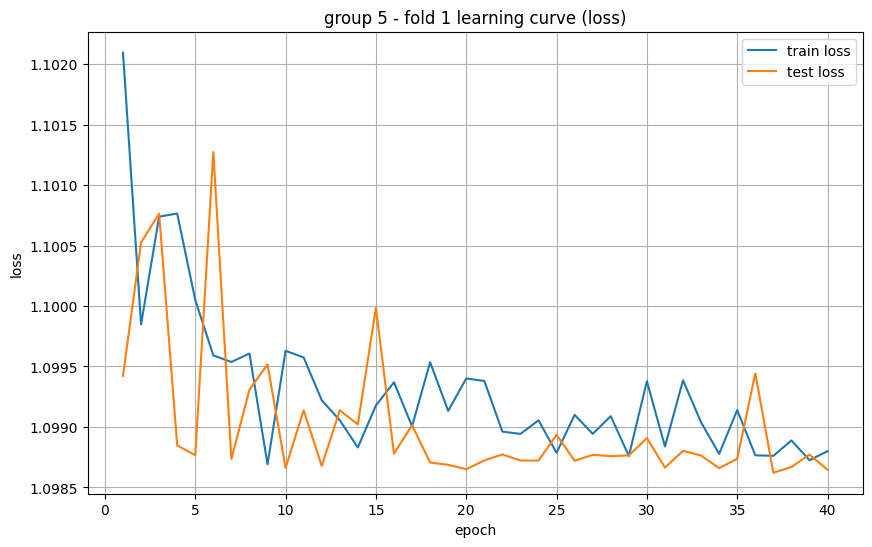

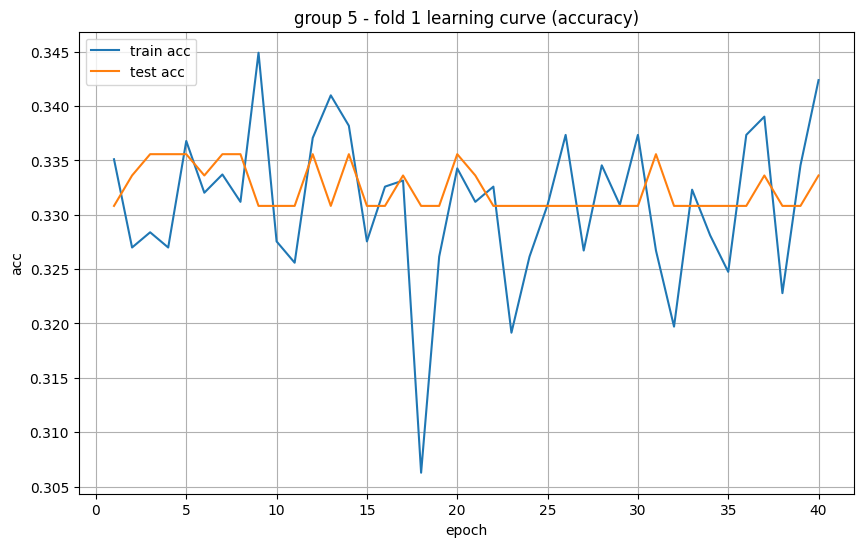

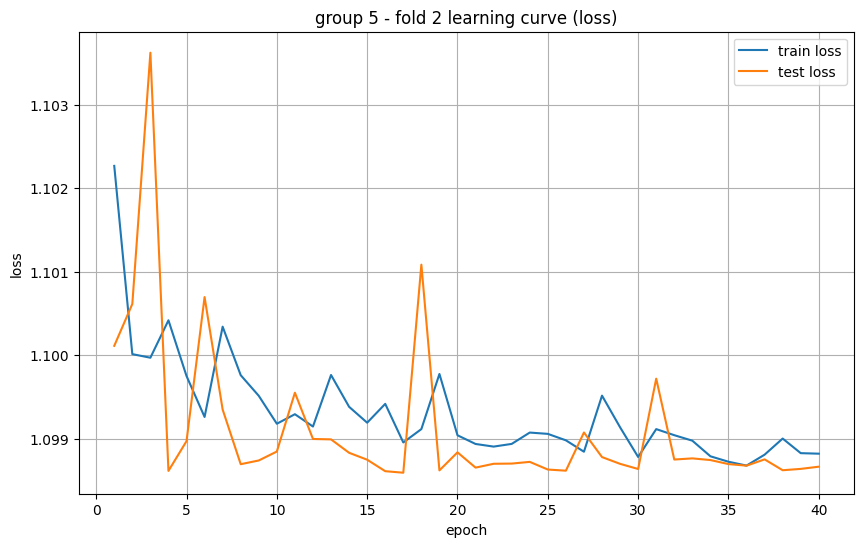

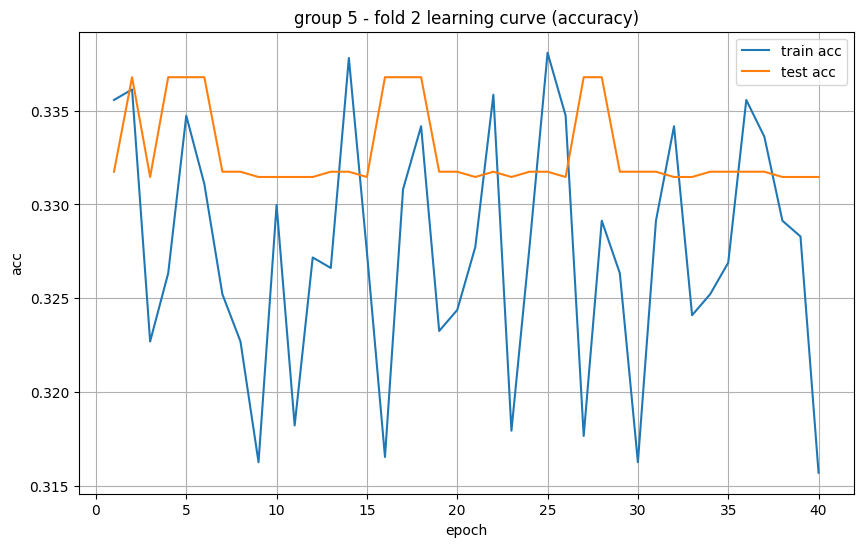

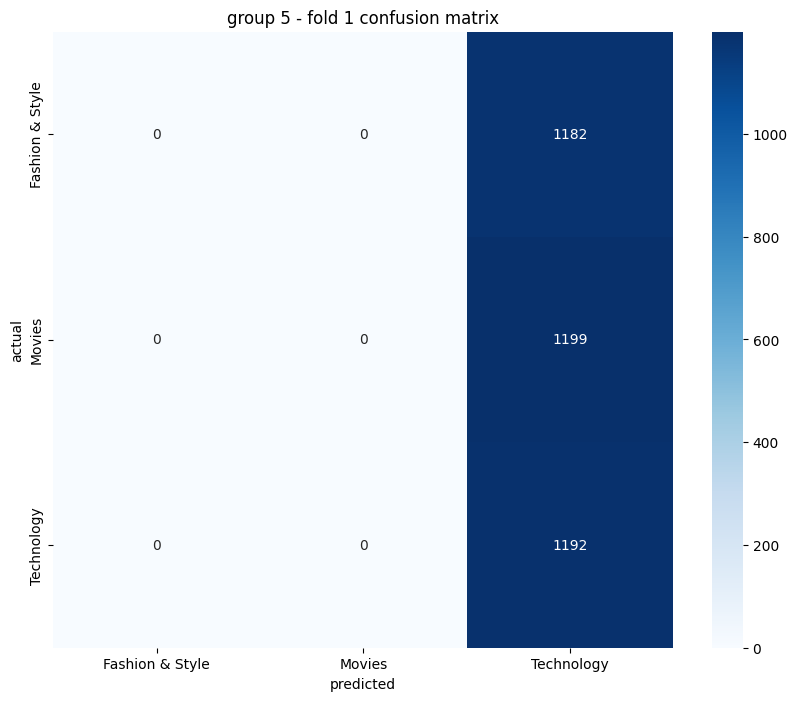

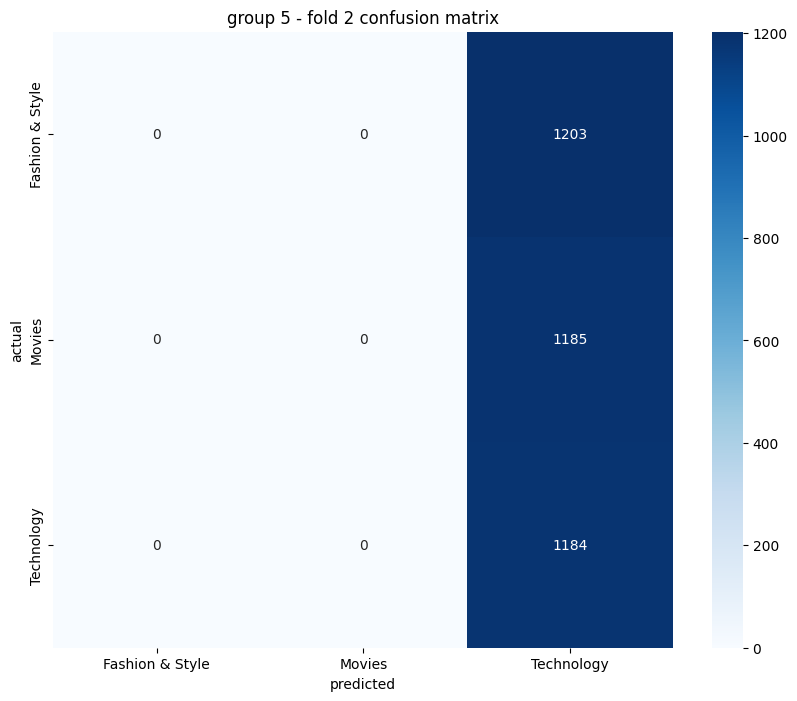


group 6 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1016, train acc: 0.3296
                               test loss: 1.0983, test acc: 0.3421
    epoch 5/40: train loss: 1.1001, train acc: 0.3358
                               test loss: 1.0981, test acc: 0.3441
    epoch 10/40: train loss: 1.0986, train acc: 0.3398
                               test loss: 1.0985, test acc: 0.3421
    epoch 15/40: train loss: 1.0984, train acc: 0.3378
                               test loss: 1.0978, test acc: 0.3421
    epoch 20/40: train loss: 1.0980, train acc: 0.3474
                               test loss: 1.0980, test acc: 0.3421
    epoch 25/40: train loss: 1.0978, train acc: 0.3343
                               test loss: 1.0979, test acc: 0.3421
    epoch 30/40: train loss: 1.0979, train acc: 0.3471
                               test loss: 1.0983, test acc: 0.3441
    epoch 35/40: train loss: 1.0979, train acc: 0.3419
                               test loss: 1.0978, test a

/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Minju/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



  fold 2/2 처리 중...
    epoch 1/40: train loss: 1.1028, train acc: 0.3368
                               test loss: 1.0976, test acc: 0.3454
    epoch 5/40: train loss: 1.0989, train acc: 0.3496
                               test loss: 1.0979, test acc: 0.3454
    epoch 10/40: train loss: 1.0992, train acc: 0.3377
                               test loss: 1.0976, test acc: 0.3439
    epoch 15/40: train loss: 1.0982, train acc: 0.3400
                               test loss: 1.0974, test acc: 0.3439
    epoch 20/40: train loss: 1.0986, train acc: 0.3400
                               test loss: 1.0975, test acc: 0.3454
    epoch 25/40: train loss: 1.0984, train acc: 0.3371
                               test loss: 1.0976, test acc: 0.3454


In [ ]:
EPOCHS = 40
BATCH_SIZE = 32
K_FOLDS = 2
results = []
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 128
LATENT_DIM = 64
LATENT_SIZE = 64  # Latent의 수
NUM_BLOCKS = 4    # PerceiverBlock의 수
LR = 1e-3

all_learning_curves = []
best_models = {} 

for idx, group_file in enumerate(output_paths, start=1):
    print(f"\ngroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df, tokenizer=tokenizer, MAX_LENGTH=MAX_LENGTH)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)

    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_results = []
    fold_learning_curves = []
    best_fold_acc = 0.0
    best_model = None
    best_valid_loader = None

    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset), start=1):
        print(f"\n  fold {fold}/{K_FOLDS} 처리 중...")

        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

        perceiver = Perceiver(
            input_dim=EMBED_DIM,
            latent_dim=LATENT_DIM,
            latent_size=LATENT_SIZE,
            num_classes=num_classes,
            num_blocks=NUM_BLOCKS,
            self_attn_layers_per_block=1
        )

        model = CombinedModel(
            vocab_size=VOCAB_SIZE,
            embed_dim=EMBED_DIM,
            perceiver_model=perceiver
        )
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LR)  
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        for epoch in range(EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            scheduler.step()

            current_lr = LR
            current_lr = scheduler.get_last_lr()[0]
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f'    epoch {epoch+1}/{EPOCHS}: train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')
                print(f'                               test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')
        if test_acc > best_fold_acc:
            best_fold_acc = test_acc
            best_model = model
            best_valid_loader = test_loader

        fold_learning_curves.append({
            "Fold": fold,
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies
        })

        
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                input_ids_batch = batch['input_ids'].to(device)
                attention_mask_batch = batch['attention_mask'].to(device)  
                labels_batch = batch['labels'].to(device)

                outputs = model(input_ids_batch)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels_batch.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)
        fold_results.append({
            "Fold": fold,
            "Test Accuracy": test_acc,
            "Confusion Matrix": cm,
            "Classification Report": report
        })
    

    # 모델 및 데이터로더 저장장
    model_save_path = f"{model_path}/text_model_{idx}.pkl"
    torch.save(best_model, model_save_path)
    print(f"Group {idx} 최고 모델 저장 완료: {model_save_path}")

    # val_loader_save_path = f"{loader_path}/text_val_loader_{idx}.pkl"
    # with open(val_loader_save_path, 'wb') as f:
    #     pickle.dump(best_valid_loader, f) 
    # print(f"Group {idx} 최고 valid loader 저장 완료: {val_loader_save_path}")
    
    
    # 결과 Analysis
    avg_accuracy = np.mean([fr["Test Accuracy"] for fr in fold_results])
    results.append({
        "Group": idx,
        "Average Test Accuracy": avg_accuracy,
        "Fold Results": fold_results
    })

    all_learning_curves.append({
        "Group": idx,
        "Fold Learning Curves": fold_learning_curves
    })

  
    print(f"\n그룹 {idx}의 {K_FOLDS} 폴드 평균 테스트 정확도: {avg_accuracy:.4f}")

    for fold_result in fold_results:
        print(f"\n  폴드 {fold_result['Fold']} 결과:")
        print(f"    테스트 정확도: {fold_result['Test Accuracy']:.4f}")
        print(pd.DataFrame(fold_result['Classification Report']).transpose())

    for curve in fold_learning_curves:
        fold_idx = curve["Fold"]

        
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_losses"], label="train loss")
        plt.plot(range(1, EPOCHS + 1), curve["test_losses"], label="test loss")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (loss)")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.grid(True)
        plt.show()

   
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_accuracies"], label="train acc")
        plt.plot(range(1, EPOCHS + 1), curve["test_accuracies"], label="test acc")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (accuracy)")
        plt.xlabel("epoch")
        plt.ylabel("acc")
        plt.legend()
        plt.grid(True)
        plt.show()

    
    for fold_result in fold_results:
        fold_idx = fold_result["Fold"]
        cm = fold_result["Confusion Matrix"]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_encoder.classes_, 
                    yticklabels=label_encoder.classes_)
        plt.title(f"group {idx} - fold {fold_idx} confusion matrix")
        plt.xlabel("predicted")
        plt.ylabel("actual")
        plt.show()

print("\n=== 모든 그룹의 요약 결과 ===")
for result in results:
    group_idx = result["Group"]
    avg_acc = result["Average Test Accuracy"]
    print(f"\n그룹 {group_idx} - 평균 테스트 정확도: {avg_acc:.4f}")
    for fold_result in result["Fold Results"]:
        fold_idx = fold_result["Fold"]
        fold_acc = fold_result["Test Accuracy"]
        print(f"  폴드 {fold_idx}: 테스트 정확도 = {fold_acc:.4f}")

In [9]:
import pickle

file_path = "/home/youlee/perceiver/perceiver/loader/text_val_loader_1.pkl"

with open(file_path, "rb") as file:
    data = pickle.load(file)

type_of_data = type(data)
if hasattr(data, 'shape'):
    data_shape = data.shape
else:
    try:
        data_shape = (len(data), len(data[0]))
    except Exception as e:
        data_shape = f"Cannot determine shape: {e}"

type_of_data, data_shape


(torch.utils.data.dataloader.DataLoader,
 "Cannot determine shape: 'DataLoader' object is not subscriptable")

In [10]:
for batch in data:
  
    if isinstance(batch, dict):
        print({key: value.shape for key, value in batch.items()})

    elif isinstance(batch, tuple):
        print(f"Inputs shape: {batch[0].shape}, Labels shape: {batch[1].shape}")
    else:
        print(f"Unknown batch format: {type(batch)}")
    break  

{'input_ids': torch.Size([32, 128]), 'attention_mask': torch.Size([32, 128]), 'labels': torch.Size([32])}
